### Product Recommender for Customers

Understanding the customer attrition and market demand is crucial for a business. This project explores the machine learning methodologies to process transactioanl records efficiently by focusing on the differences between customers, product families, products across all the regions and purchasing types.


In [200]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from functools import partial
import ipywidgets as widgets
from IPython.display import display
from joblib import Parallel, delayed
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import sparse, stats
from scipy.sparse import csr_matrix
from scipy.stats import norm
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')
from scipy.cluster.hierarchy import linkage, cut_tree
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



In [201]:
# Read sales data file 
data = pd.read_csv('data/Yearly_Sales_Data.csv')

In [202]:
# Shape and preview
print(' DataFrame Shape :',data.shape)
pd.set_option('display.max_columns', None)
data.head()

 DataFrame Shape : (600105, 11)


,Customer,Customer_Group,Product_Family,Product_Bus_Group,Product_Number,Region,Sales_Order_Number,Sales_Type,Quantity,Order_Value,Order_Ship_Date
0,Cust1,CustGroup 1,CM1-Family1,PG1,PN1,Region1,SO1,Part Subscription,3.0,91.56,3/18/2021
1,Cust3,CustGroup 2,CM4-Family4,PG1,PN4,Region2,SO4,Transactional,1035.0,80011.92,2/27/2021
2,Cust5,CustGroup 1,CM6-Family8,PG4,PN8,Region1,SO8,Part Subscription,13.0,6517.00,3/24/2021
3,Cust6,CustGroup 1,CM3-Family9,PG4,PN9,Region1,SO9,Part Subscription,15.0,1230.90,2/27/2021
4,Cust7,CustGroup 4,CM2-Family10,PG5,PN10,Region2,SO10,Transactional,5.0,19605.00,3/19/2021


In [203]:
df= pd.DataFrame(data)

In [204]:
df.describe()
df.dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600105 entries, 0 to 600104
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Customer            600105 non-null  object 
 1   Customer_Group      600105 non-null  object 
 2   Product_Family      600105 non-null  object 
 3   Product_Bus_Group   600105 non-null  object 
 4   Product_Number      600105 non-null  object 
 5   Region              600105 non-null  object 
 6   Sales_Order_Number  600105 non-null  object 
 7   Sales_Type          600105 non-null  object 
 8   Quantity            600105 non-null  float64
 9   Order_Value         600105 non-null  float64
 10  Order_Ship_Date     600105 non-null  object 
dtypes: float64(2), object(9)
memory usage: 50.4+ MB


In [205]:
# Column value analysis
def describe (data, columns):
    selected_data = data[columns]

    # Generate descriptive statistics using pandas
    description = selected_data.describe()

    #Calculate additional statistics using scipy
    skewness = stats.skew(selected_data, nan_policy ='omit')
    kurtosis = stats.kurtosis(selected_data, nan_policy = 'omit')

    description.loc['skew'] = skewness
    description.loc['kurtosis'] = kurtosis

    return description

descriptive_stats = describe(data,['Quantity', 'Order_Value'])
print(descriptive_stats)                             

               Quantity   Order_Value
count     600105.000000  6.001050e+05
mean          27.339930  4.856883e+03
std          216.527226  2.592521e+04
min           -3.000000 -5.768520e+03
25%            3.000000  1.094000e+02
50%            5.000000  6.226800e+02
75%           13.000000  2.589860e+03
max        32861.000000  3.763969e+06
skew          66.878186  3.073061e+01
kurtosis    7043.791744  1.913642e+03


In [206]:
sales_quantiles = data['Quantity'].quantile([0.25,0.5,0.75], interpolation = 'nearest')
value_quantiles = data['Order_Value'].quantile([0.25,0.5,0.75], interpolation = 'nearest')

print("Sale Quantity Qunatiles:\n", sales_quantiles)
print("Order Value Qunatiles:\n", value_quantiles)


Sale Quantity Qunatiles:
 0.25     3.0
0.50     5.0
0.75    13.0
Name: Quantity, dtype: float64
Order Value Qunatiles:
 0.25     109.40
0.50     622.68
0.75    2589.86
Name: Order_Value, dtype: float64


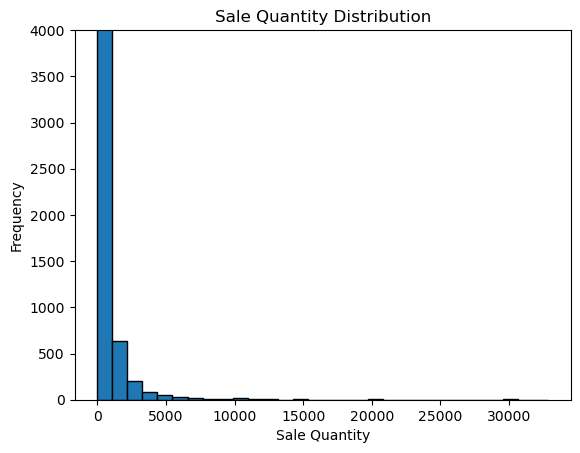

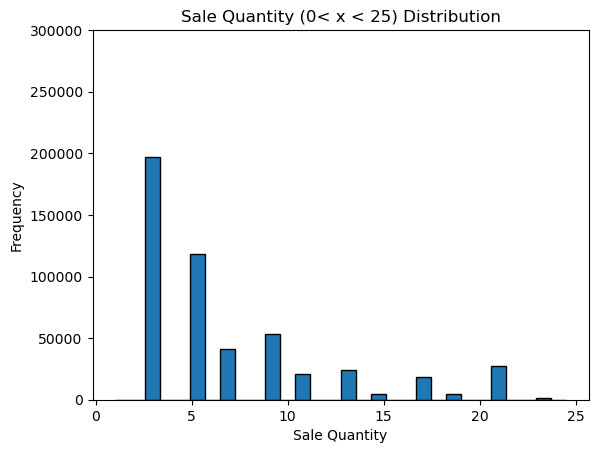

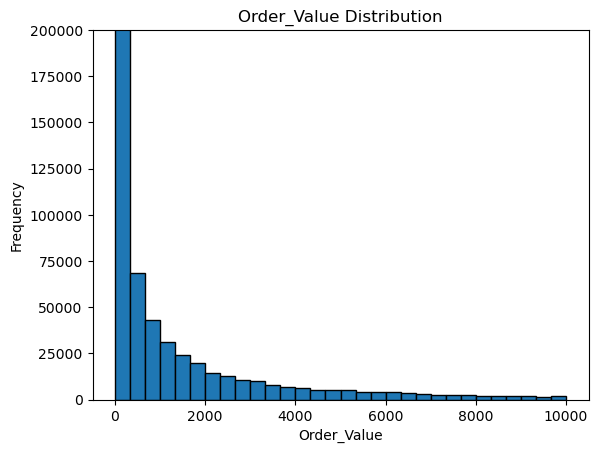

In [207]:
# Histograms for Quantity and Order Value

plt.hist(data['Quantity'], bins= 30, edgecolor = 'black')
plt.ylim(0, 4000)
plt.title ( 'Sale Quantity Distribution')
plt.xlabel('Sale Quantity')
plt.ylabel('Frequency')
plt.show()

# Filtered Histogram for Sales Quantity between 0 and 25
filtered_df = data[(data['Quantity']>0 ) & (data['Quantity'] < 25)]
plt.hist(filtered_df['Quantity'], bins = 30, edgecolor = 'black')
plt.ylim(0, 300000)
plt.title ( 'Sale Quantity (0< x < 25) Distribution')
plt.xlabel('Sale Quantity')
plt.ylabel('Frequency')
plt.show()

# Histogram for order value
filtered_df = data[(data['Order_Value']>0 ) & (data['Order_Value'] < 10000)]
plt.hist(filtered_df['Order_Value'], bins= 30, edgecolor = 'black')
plt.ylim(0, 200000)
plt.title ( 'Order_Value Distribution')
plt.xlabel('Order_Value')
plt.ylabel('Frequency')
plt.show()


In [208]:
high_sales = data[data['Quantity'] > 30000]
print(high_sales)

       Customer Customer_Group Product_Family Product_Bus_Group  \
88244    Cust23    CustGroup 6    CM3-Family7               PG9   
175757   Cust71    CustGroup 6    CM3-Family9               PG6   
241151   Cust23    CustGroup 6    CM3-Family7               PG9   
249659   Cust71    CustGroup 6    CM3-Family7               PG9   
338141   Cust42    CustGroup 2    CM3-Family7               PG9   
344448   Cust71    CustGroup 6    CM3-Family7               PG9   
347673   Cust71    CustGroup 6    CM3-Family7               PG9   

       Product_Number   Region Sales_Order_Number         Sales_Type  \
88244           PN690  Region2            SO95540  Part Subscription   
175757         PN2107  Region2             SO5141  Part Subscription   
241151          PN690  Region2            SO75164  Part Subscription   
249659          PN690  Region2            SO84766  Part Subscription   
338141          PN690  Region6           SO326771      Transactional   
344448          PN690  Region2 

In [209]:
# Print percentage of Columns that are null in relation to the total number of columns
for column in data.columns:
    if data[column].isnull().sum() > 0:
        print(column, ': {:.2%}'.format(data[column].isnull().sum() /
                                               data[column].shape[0]))

In [210]:
#Check the number of Null Columns
data.isnull().sum()

Customer              0
Customer_Group        0
Product_Family        0
Product_Bus_Group     0
Product_Number        0
Region                0
Sales_Order_Number    0
Sales_Type            0
Quantity              0
Order_Value           0
Order_Ship_Date       0
dtype: int64

## Create a summary table for customer level metrics

Trace down the unique customers and their purchasing patterns on various products by calcuating the order value and the quantity of individaul products.

In [212]:
# Create a summary table for customer level metrics

unique_customers = data['Customer'].unique()
customers = pd.DataFrame(index= unique_customers, columns= ['Sales_order_count', 'Unique_parts','Quantity','Order_Value'])

customers['Sales_order_count'] = data['Customer'].value_counts()

for cust in unique_customers:
    cust_filter = data[data['Customer'] == cust]
    customers.at[cust,'Unique_parts'] = cust_filter['Product_Number'].nunique()
    customers.at[cust,'Quantity'] = cust_filter['Quantity'].sum()
    customers.at[cust,'Order_Value'] = cust_filter['Order_Value'].sum()

customers = customers.apply(pd.to_numeric)
print(customers.describe())

customers.head()
    

       Sales_order_count  Unique_parts      Quantity   Order_Value
count         195.000000    195.000000  1.950000e+02  1.950000e+02
mean         3077.461538    658.410256  8.413758e+04  1.494687e+07
std          6225.552350    959.500894  2.102584e+05  3.225832e+07
min             1.000000      1.000000  3.000000e+00  1.310000e+02
25%            27.000000     20.000000  5.165000e+02  3.345432e+05
50%           570.000000    270.000000  1.061700e+04  3.135185e+06
75%          3074.500000    957.500000  7.371950e+04  1.108196e+07
max         44074.000000   5452.000000  1.637009e+06  2.310869e+08


,Sales_order_count,Unique_parts,Quantity,Order_Value
Cust1,17874,2011,460534.0,67454044.30
Cust3,4945,1942,72129.0,31762559.70
Cust5,7973,1343,140135.0,12413554.64
Cust6,3369,1619,53223.0,27216272.38
Cust7,5,5,59.0,23213.96


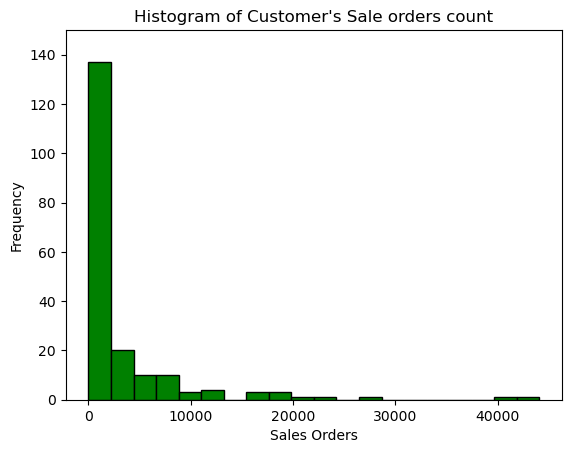

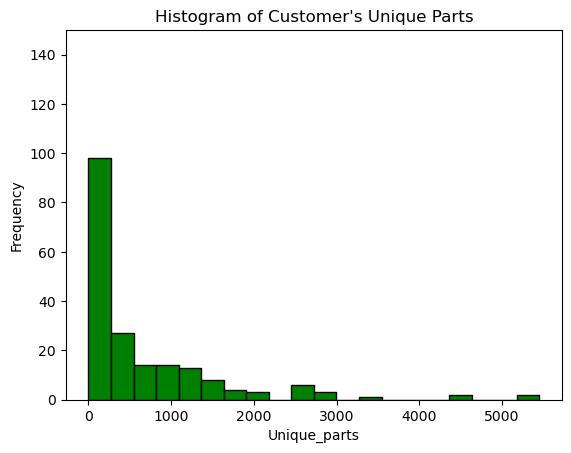

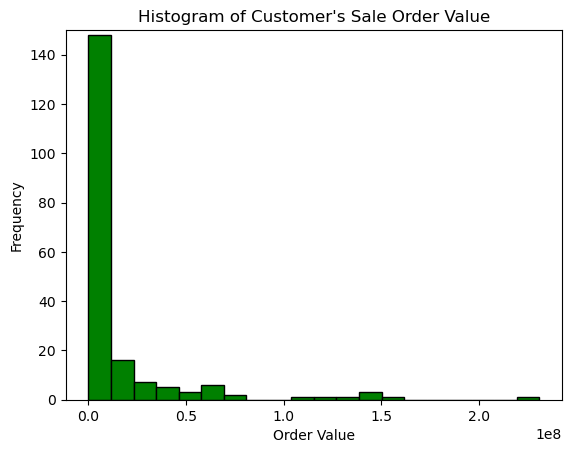

In [213]:
# Univariate Distributions - Frequencis by Customers

# Histogram for Sales orders
plt.hist(customers['Sales_order_count'] , bins = 20, color = 'green', edgecolor = 'black')
plt.ylim(0,150)
plt.title("Histogram of Customer's Sale orders count")
plt.xlabel('Sales Orders')
plt.ylabel('Frequency')
plt.show()


# Histogram for Unique Parts
plt.hist(customers['Unique_parts'] , bins = 20, color = 'green', edgecolor = 'black')
plt.ylim(0,150)
plt.title("Histogram of Customer's Unique Parts")
plt.xlabel('Unique_parts')
plt.ylabel('Frequency')
plt.show()

# Histogram for Sales order Value
plt.hist(customers['Order_Value'] , bins = 20, color = 'green', edgecolor = 'black')
plt.ylim(0,150)
plt.title("Histogram of Customer's Sale Order Value")
plt.xlabel('Order Value')
plt.ylabel('Frequency')
plt.show()

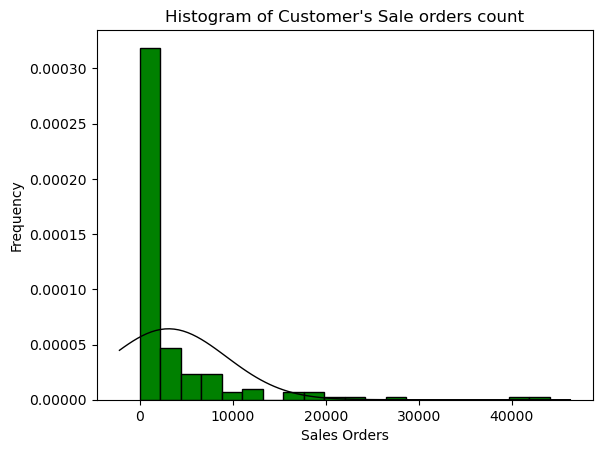

In [214]:
# Hoistogram wiht Normal distributioin curve

plt.hist(customers['Sales_order_count'] , bins = 20, color = 'green', density = True, edgecolor = 'black')
params = norm.fit(customers['Sales_order_count'])
x= np.linspace(*plt.xlim(),100)
plt.plot(x,norm.pdf(x,*params), 'k', linewidth = 1)
plt.title("Histogram of Customer's Sale orders count")
plt.xlabel('Sales Orders')
plt.ylabel('Frequency')
plt.show()


### Pivot the data such as rows record customers and column record product families
Since the data set is huge and have various types of products, a few high in order value and a few high in order quantity.
A pivoted table containing these would be much too wide an d difficult to interpret. 

We create 3 pivot tables

1. Records order values
2. Records order quantities for a specific part
3. 3 records order frequencies


In [216]:
# Aggregate all traqnsactions from each customer - product family pair  in to a row

cleaned_aggr = data.groupby (['Customer', 'Product_Family'], as_index = False).agg(
    Total_Sales = pd.NamedAgg(column = 'Quantity', aggfunc = 'sum'),
    Total_Value = pd.NamedAgg(column = 'Order_Value', aggfunc = 'sum'),
    Frequency = pd.NamedAgg(column = 'Quantity', aggfunc = 'count')
)

print(cleaned_aggr.head())
    

  Customer Product_Family  Total_Sales  Total_Value  Frequency
0    Cust1    CM1-Family1     117026.0   2334334.64       3832
1    Cust1  CM1-Family245        179.0     98375.58          9
2    Cust1   CM1-Family35      10807.0    416271.48        497
3    Cust1   CM1-Family50      48209.0    306231.26        639
4    Cust1   CM1-Family59        694.0    462027.30         80


In [217]:
# Pivot table for Total Sales Order Value
piv_vals = cleaned_aggr.pivot(index='Customer', columns = 'Product_Family',values = 'Total_Value').fillna(0)
matrix_vals = piv_vals.to_numpy()
matrix_vals_df = pd.DataFrame(matrix_vals, index = piv_vals.index, columns = piv_vals.columns)

# Pivot table for Total Sales Order Quantity
piv_quants = cleaned_aggr.pivot(index='Customer', columns = 'Product_Family',values = 'Total_Sales').fillna(0)
matrix_quants = piv_vals.to_numpy()
matrix_quants_df = pd.DataFrame(matrix_vals, index = piv_vals.index, columns = piv_vals.columns)

# Pivot table for Total Sale Order Frequency
piv_freqs = cleaned_aggr.pivot(index='Customer', columns = 'Product_Family',values = 'Frequency').fillna(0)
matrix_freqs = piv_vals.to_numpy()
matrix_freqs_df = pd.DataFrame(matrix_vals, index = piv_vals.index, columns = piv_vals.columns)

### Block Clustering

Trying to find the blocks in the entire dataset ( using a default of 2 buy 3 clusters with out subsetting for now)

In [219]:
log_vals = np.log1p(matrix_vals)
log_quants = np.log1p(matrix_quants)
log_freqs = np.log1p(matrix_freqs)

In [220]:
# Generate Heatmaps with hierarchical clustering


def generate_heatmap(matrix, title, filename):
    row_linkage = linkage(matrix, method = 'ward')
    col_linkage = linkage(matrix.T, method = 'ward')


    row_clusters = cut_tree(row_linkage, n_clusters= 2).flatten()
    col_clusters = cut_tree(col_linkage, n_clusters= 2).flatten()

    sns.clustermap(matrix, row_linkage= row_linkage, col_linkage= col_linkage, cmap = "coolwarm",row_cluster = True, col_cluster = True,
                    cbar_kws = {'label': 'log transformed values'}, 
                    xticklabels = False, yticklabels = False)
    plt.title(title)
    plt.savefig(filename)
    plt.show()


    row_cluster_1 = matrix.index[row_clusters == 0]
    col_cluster_1 = matrix.columns[col_clusters == 0]
    row_cluster_1.to_series().to_csv("cust_selction.csv", index = False)
    col_cluster_1.to_series().to_csv("part_family_selection.csv", index= False)

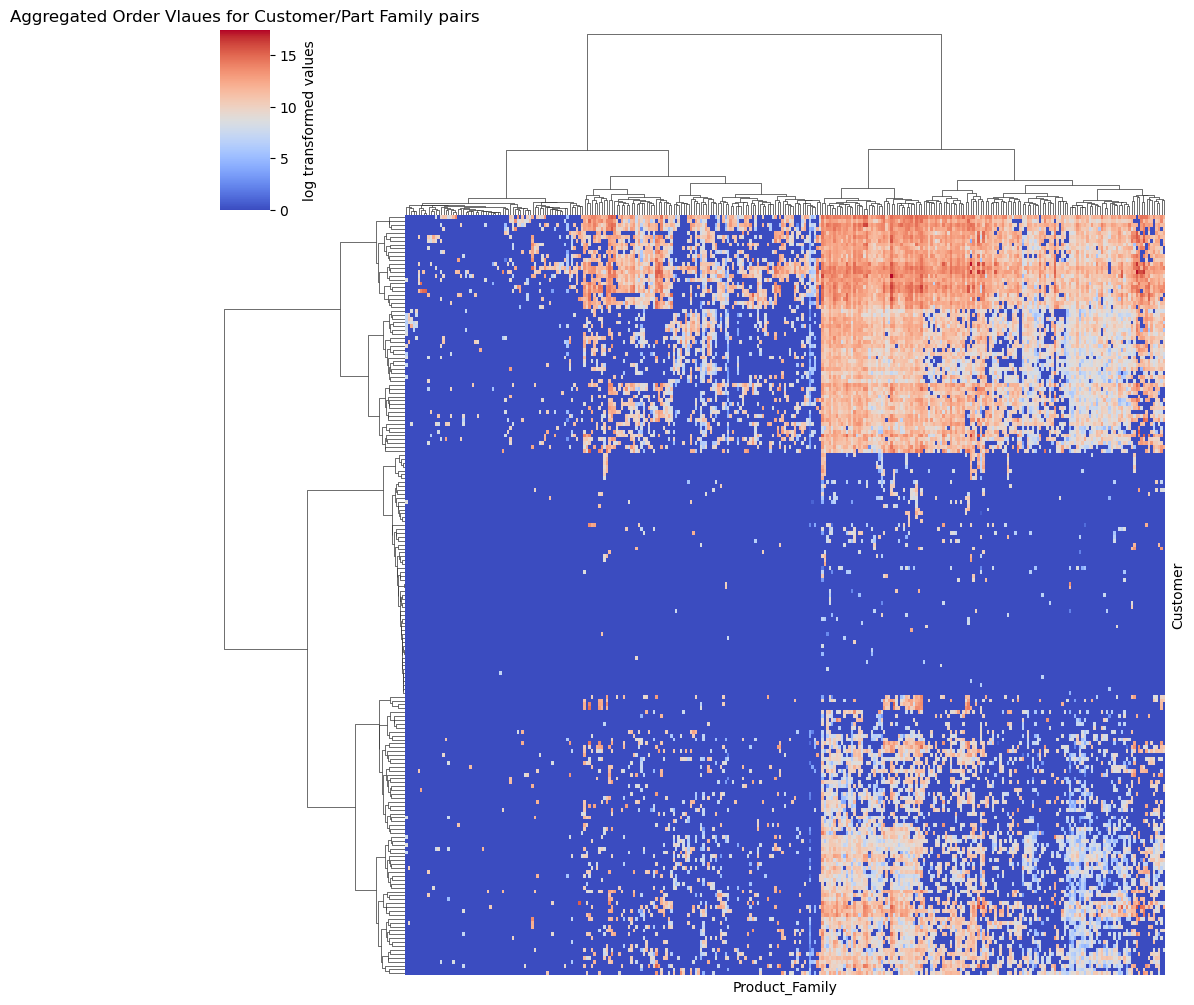

In [221]:
 # Heat map for log vals

generate_heatmap(pd.DataFrame(log_vals, index=piv_vals.index, columns = piv_vals.columns),
                  "Aggregated Order Vlaues for Customer/Part Family pairs", "order_values_heatmap.png")

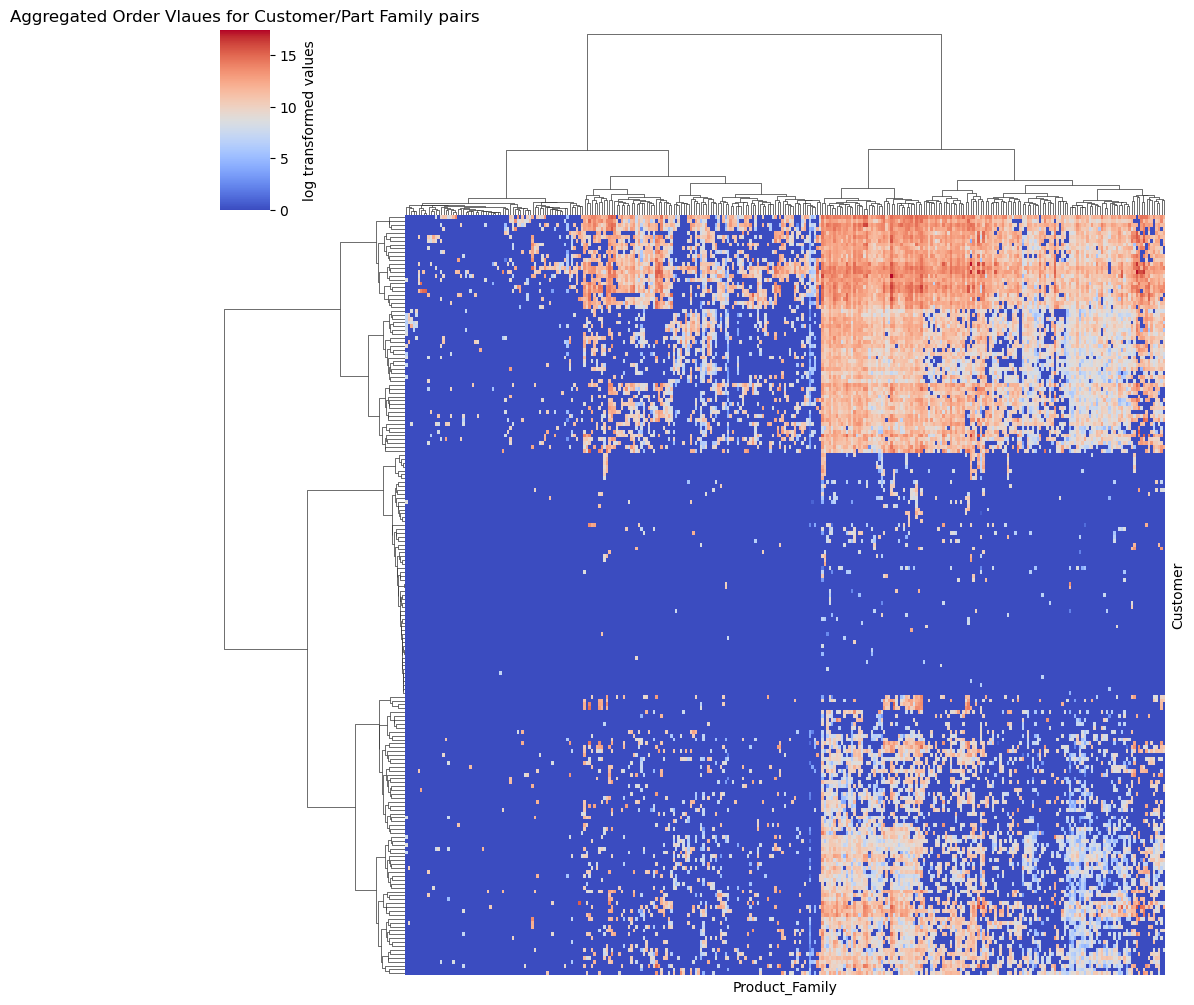

In [222]:
# Heat map for log quantity

generate_heatmap(pd.DataFrame(log_quants, index=piv_quants.index, columns = piv_quants.columns),
                  "Aggregated Order Vlaues for Customer/Part Family pairs", "order_Quantity_heatmap.png")

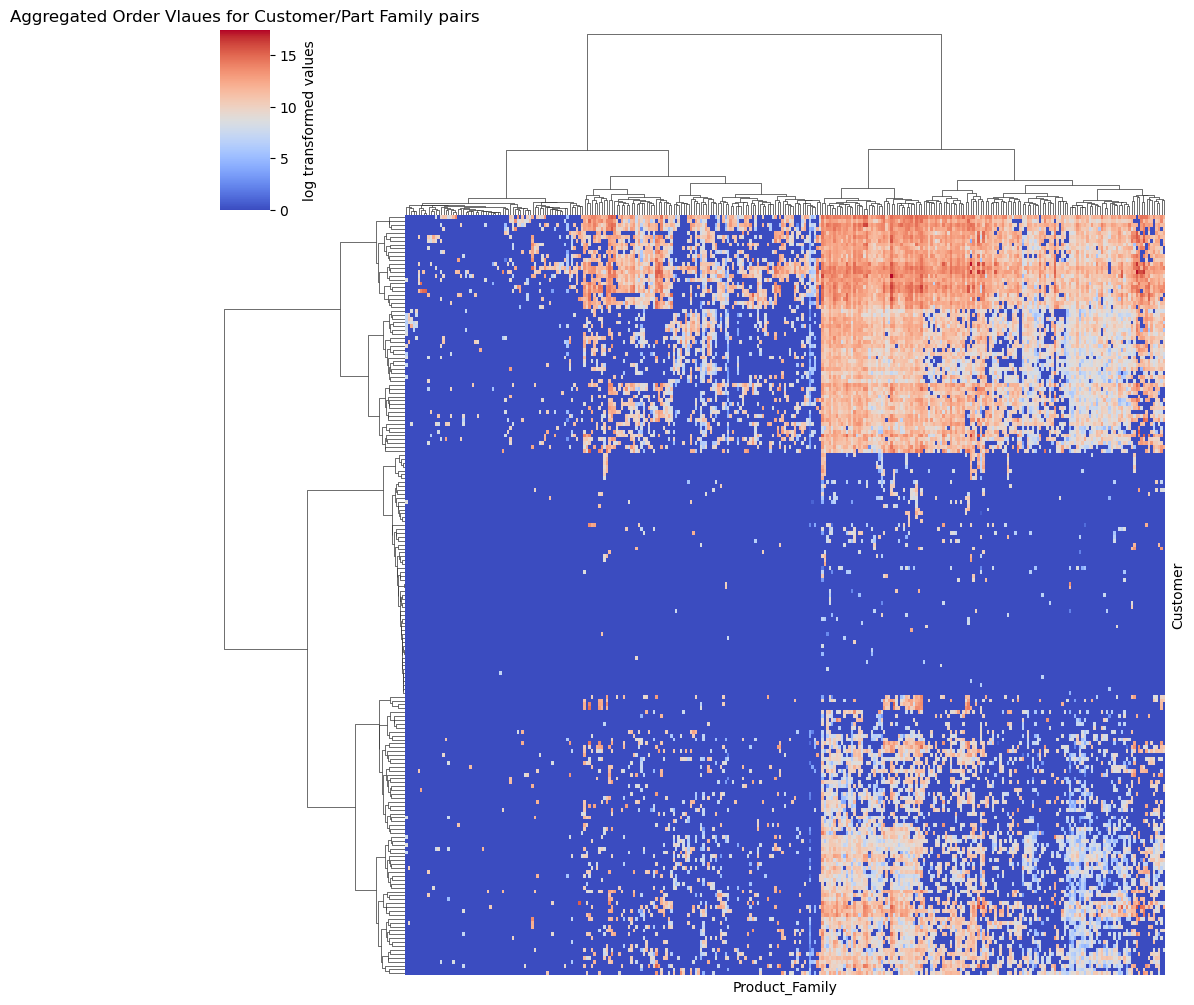

In [223]:
# Heat map for log frequency

generate_heatmap(pd.DataFrame(log_freqs, index=piv_freqs.index, columns = piv_freqs.columns),
                  "Aggregated Order Vlaues for Customer/Part Family pairs", "order_frequency_heatmap.png")

In [224]:
# Block custering Model based

def cocluster(matrix, n_row_clusters, n_col_clusters):
    row_clusters = KMeans(n_clusters= n_row_clusters, random_state =0).fit_predict(matrix)
    col_clusters = KMeans(n_clusters= n_col_clusters, random_state =0).fit_predict(matrix.T)
    return row_clusters, col_clusters

row_freqs, col_freqs = cocluster(matrix_freqs,2,3)
row_quants, col_quants = cocluster(matrix_quants,2,3)
row_vals, col_vals = cocluster(matrix_vals,2,3)


#Classification tables
pd.crosstab(row_freqs, row_quants)
pd.crosstab(col_freqs, col_quants)


#Grid search for best Model
results = []
for i in range(2,5):
    for j in range(2,5):
        scores = []
        for _ in range(5):
            r,_ = cocluster(matrix_freqs,i,j)
            scores.append(silhouette_score(matrix_freqs,r))
            results.append(((i,j),np.mean(scores)))


best = min(results, key = lambda x:x[1])
print("Best model(row, col clusters):", best[0],"with avg silhouette:", best[1])

Best model(row, col clusters): (4, 2) with avg silhouette: 0.7738142091196871


In [254]:
# Maximum likelihood for each model
max_rows = 5
max_cols = 5
n_repeats = 100
best_models = []

for  i  in range(2, max_rows + 1):
    for j in range(2, max_cols+ 1):
        best_likelihood = -np.inf
        best_result = None

        for rep in range(n_repeats):
            row_clusters = KMeans(n_clusters =i,
                                  random_state = rep).fit_predict(matrix_freqs)
            col_clusters = KMeans(n_clusters = j, random_state =rep).fit_predict(matrix_freqs.T)
            
            likelihood = silhouette_score(matrix_freqs, row_clusters)

            if likelihood> best_likelihood:
                best_likelihood = likelihood
                best_result = {
                     'Row_Clusters':i,
                     'Col_Clusters':j,
                     'Likelihood':likelihood,
                    'ICL': likelihood
                }


        if best_result:
                 best_models.append(best_result)

results_grid = pd.DataFrame(best_models)
results_grid.to_csv("best_models.csv", index = False)
print(results_grid)

    Row_Clusters  Col_Clusters  Likelihood       ICL
0              2             2    0.903450  0.903450
1              2             3    0.903450  0.903450
2              2             4    0.903450  0.903450
3              2             5    0.903450  0.903450
4              3             2    0.895494  0.895494
5              3             3    0.895494  0.895494
6              3             4    0.895494  0.895494
7              3             5    0.895494  0.895494
8              4             2    0.890404  0.890404
9              4             3    0.890404  0.890404
10             4             4    0.890404  0.890404
11             4             5    0.890404  0.890404
12             5             2    0.792509  0.792509
13             5             3    0.792509  0.792509
14             5             4    0.792509  0.792509
15             5             5    0.792509  0.792509


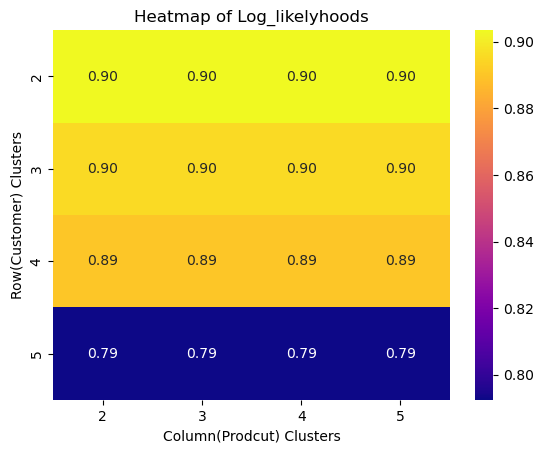

In [255]:
# Heat map for Likelihood


sns.heatmap(results_grid.pivot(index = 'Row_Clusters',columns = 'Col_Clusters',values = 'Likelihood'),cmap = 'plasma', annot= True, fmt = '.2f')
plt.title('Heatmap of Log_likelyhoods')
plt.xlabel('Column(Prodcut) Clusters')
plt.ylabel('Row(Customer) Clusters')
plt.show()

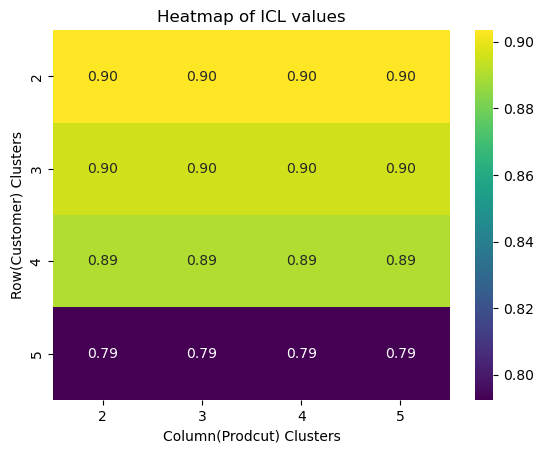

In [256]:
# Heat map for ICL s


sns.heatmap(results_grid.pivot(index = 'Row_Clusters',columns = 'Col_Clusters',values = 'ICL'),cmap = 'viridis', annot= True, fmt = '.2f')
plt.title('Heatmap of ICL values')
plt.xlabel('Column(Prodcut) Clusters')
plt.ylabel('Row(Customer) Clusters')
plt.show()

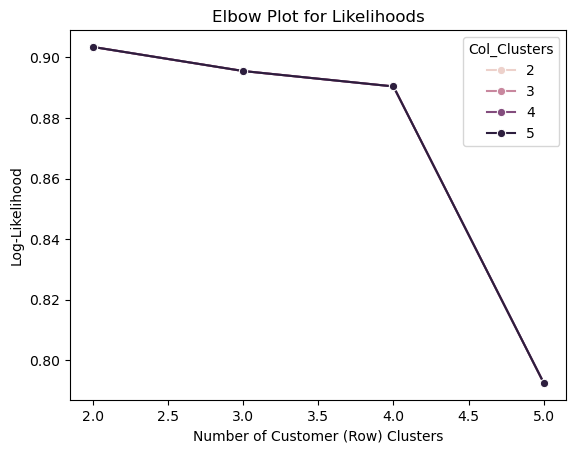

In [257]:
# Elbow Plot

sns.lineplot(data = results_grid, x= 'Row_Clusters', y='Likelihood', hue = 'Col_Clusters',
             marker = 'o')
plt.title('Elbow Plot for Likelihoods')
plt.xlabel('Number of Customer (Row) Clusters')
plt.ylabel('Log-Likelihood')
plt.show()